In [ ]:
# 04/01
#数据表https://s3.amazonaws.com/dq-blog-files/input.csv
#中文版本文章https://zhuanlan.zhihu.com/p/32949396 

In [58]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

### Import data
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

df = pd.read_csv('c:/csv/input.csv')
df

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,DEM,MO,S,C,12G,15E,IND,MA,Engineer,2016.0,100.0
99996,DEM,CA,H,C,30G,15,IND,CA,Engineer,2010.0,500.0
99997,DEM,US,P,C,M6,15,IND,NJ,Engineer,2016.0,250.0
99998,DEM,US,P,C,12G,15,IND,CO,Scientist,2016.0,25.0


In [2]:
### Training and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    #X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)
xtrain, xtest, ytrain, ytest = get_train_test()

# A look at the data
print("\nExample data:")
df.head()


Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [4]:
df

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,DEM,MO,S,C,12G,15E,IND,MA,Engineer,2016.0,100.0
99996,DEM,CA,H,C,30G,15,IND,CA,Engineer,2010.0,500.0
99997,DEM,US,P,C,M6,15,IND,NJ,Engineer,2016.0,250.0
99998,DEM,US,P,C,12G,15,IND,CO,Scientist,2016.0,25.0


>***如上特征含义如下：***
1 cand_pty_affiliation, 标签项\
2 cand_office_st：候选人活动的州\
3 cand_office ：或者是在这个州居住，或者是作为这个州的候选人\
4 cand_status :判断候选人是否竞选公职或者在职\
5 rpt_tp：识别竞选期间捐款\
6 transaction_tp:捐款形式，是候选人自己捐款，还是\
7entitp_tp:捐款实体，\
8state:捐款人所在州\
9classification：所在专业领域\
10cycle:捐款时间\
11 transaction_amt：捐款金额


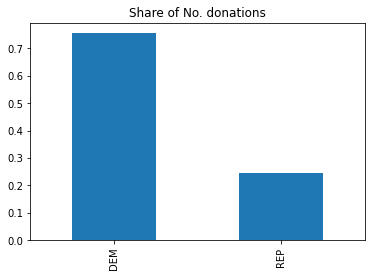

In [5]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(   #normalize =True 表示用百分数来标识
   kind="bar", title="Share of No. donations")
plt.show()

### 可视化决策树

In [8]:
import pydotplus  # you can install pydotplus with: pip install pydotplus 
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

In [9]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)

c:\users\wangk66\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


DecisionTreeClassifier(max_depth=1, random_state=222)

In [20]:
t1.predict_proba(xtest)

c:\users\wangk66\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


array([[0.617854  , 0.382146  ],
       [0.88481291, 0.11518709],
       [0.617854  , 0.382146  ],
       ...,
       [0.617854  , 0.382146  ],
       [0.617854  , 0.382146  ],
       [0.88481291, 0.11518709]])

In [21]:
t1.predict_proba(xtest)[:,1]

c:\users\wangk66\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


array([0.382146  , 0.11518709, 0.382146  , ..., 0.382146  , 0.382146  ,
       0.11518709])

Decision tree ROC-AUC score: 0.672


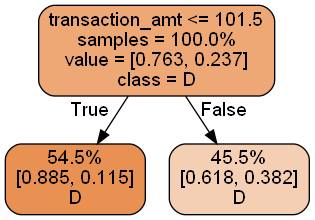

In [22]:
print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

>上图可见，所有的分类都是一类。这个和我们之前的分析矛盾，\
 上图显示，75%的捐给民主党。

c:\users\wangk66\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
c:\users\wangk66\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Decision tree ROC-AUC score: 0.751


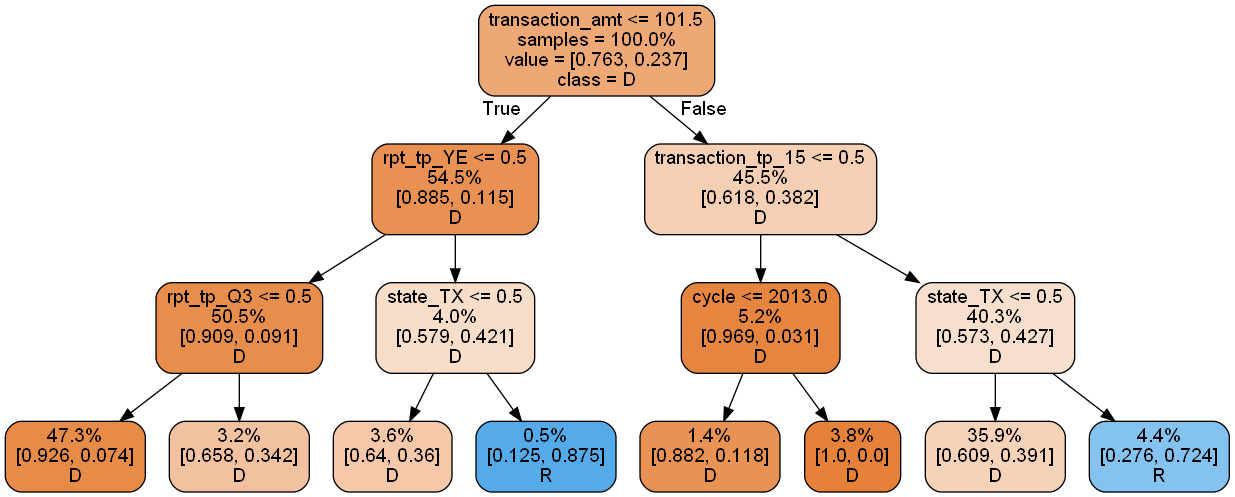

In [23]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

>*** 注意到\*** 
1 预测到R的月4.9%，和25%的训练集评估指标相差甚远；\
2 过拟合情况严重；
3 下面删除特征 transaction_amt，来降低过拟合的情况；

c:\users\wangk66\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
c:\users\wangk66\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Decision tree ROC-AUC score: 0.740


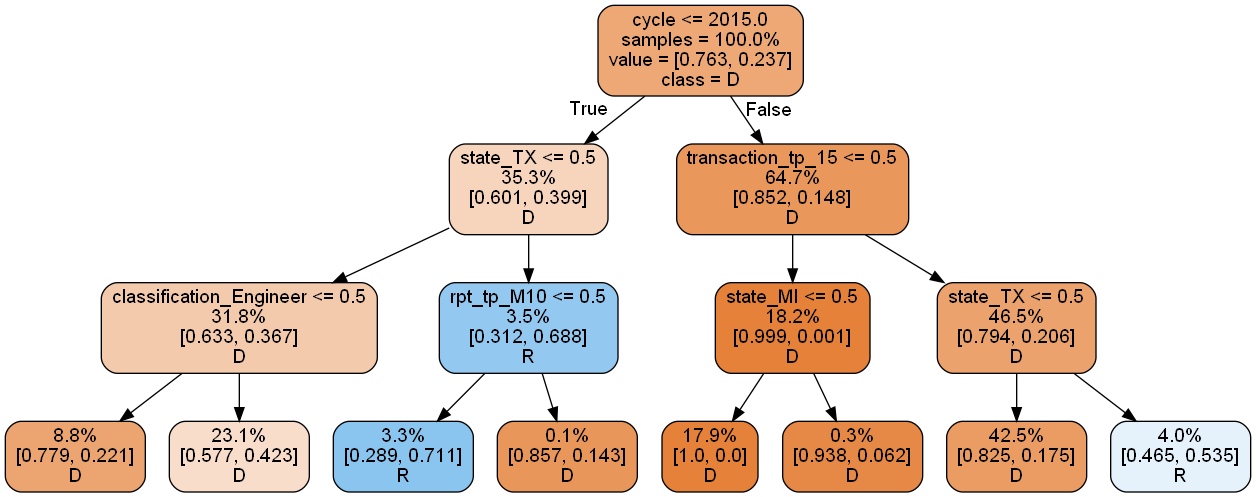

In [24]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

> score相比之前，略有下降;\
  预测R的比列月7.3,比之前略有提升；

In [31]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
"red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


### 下面采用平均法

In [32]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.783


>注意到score分值提高到0.78

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
   n_estimators=10,
   max_features=3,
   random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.844


In [35]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
             }
    return models

In [42]:
def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")
        #P.columns = cols
    print("Done.\n")
    return P

In [40]:
models = get_models()
models


{'svm': SVC(C=100, probability=True),
 'knn': KNeighborsClassifier(n_neighbors=3),
 'naive bayes': GaussianNB(),
 'mlp-nn': MLPClassifier(hidden_layer_sizes=(80, 10), random_state=222),
 'random forest': RandomForestClassifier(max_features=3, n_estimators=10, random_state=222),
 'gbm': GradientBoostingClassifier(random_state=222),
 'logistic': LogisticRegression(C=100, random_state=222)}

In [43]:
P = train_predict(models)
P

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.



,0,1,2,3,4,5,6
0,0.236360,0.333333,5.020798e-10,0.127355,0.3,0.265998,0.149704
1,0.232352,0.000000,1.085367e-68,0.001717,0.0,0.017165,0.000546
2,0.237498,0.333333,6.701134e-14,0.181957,0.2,0.328002,0.364734
3,0.234115,0.000000,2.862588e-62,0.024812,0.0,0.024914,0.004333
4,0.232964,0.000000,1.020511e-61,0.005613,0.0,0.017396,0.001141
...,...,...,...,...,...,...,...
94995,0.239265,0.666667,1.000000e+00,0.911018,1.0,0.859487,0.788745
94996,0.233575,0.000000,2.108761e-68,0.009223,0.0,0.021048,0.001792
94997,0.235493,0.000000,1.931623e-09,0.221369,0.4,0.214878,0.144859
94998,0.236375,0.333333,5.133277e-16,0.094009,0.4,0.254655,0.135917


In [47]:
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [48]:
score_models(P, ytest)

Scoring models.
0                         : 0.845
1                         : 0.779
2                         : 0.803
3                         : 0.873
4                         : 0.844
5                         : 0.878
6                         : 0.853
Done.



<AxesSubplot:>

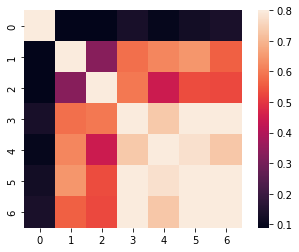

In [59]:
corrmat=P.corr()
#f,ax= plt.subplots(figsize=(20,9))
sns.heatmap(corrmat,vmax=0.8,square=True)

In [57]:
P.corr()

,0,1,2,3,4,5,6
0,1.000000,0.088330,0.088902,0.135239,0.098729,0.123816,0.136151
1,0.088330,1.000000,0.332933,0.583485,0.621119,0.645917,0.562647
2,0.088902,0.332933,1.000000,0.597138,0.445388,0.533431,0.528159
3,0.135239,0.583485,0.597138,1.000000,0.735542,0.905120,0.896589
4,0.098729,0.621119,0.445388,0.735542,1.000000,0.777893,0.730647
5,0.123816,0.645917,0.533431,0.905120,0.777893,1.000000,0.865819
6,0.136151,0.562647,0.528159,0.896589,0.730647,0.865819,1.000000


In [60]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
    for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()

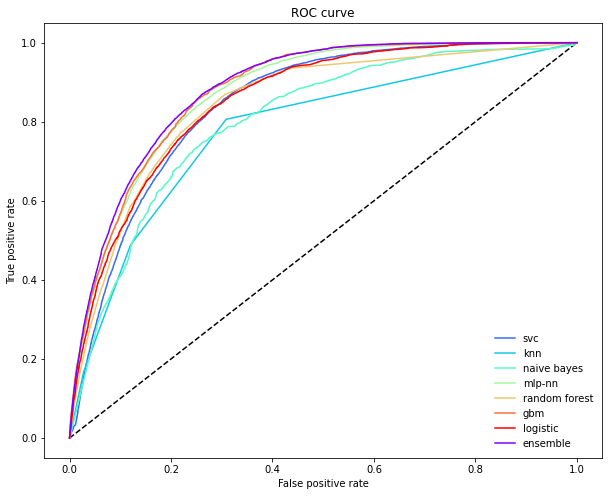

In [64]:
plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

In [63]:
P.columns=["svc","knn","naive bayes","mlp-nn","random forest","gbm","logistic"]

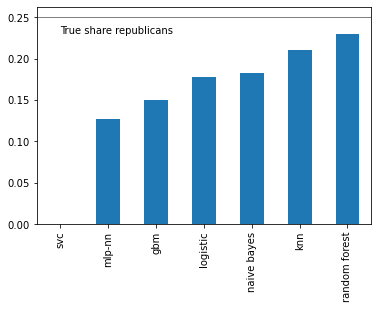

In [70]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show() 

In [71]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.880


In [73]:
base_learners = get_models()
base_learners

{'svm': SVC(C=100, probability=True),
 'knn': KNeighborsClassifier(n_neighbors=3),
 'naive bayes': GaussianNB(),
 'mlp-nn': MLPClassifier(hidden_layer_sizes=(80, 10), random_state=222),
 'random forest': RandomForestClassifier(max_features=3, n_estimators=10, random_state=222),
 'gbm': GradientBoostingClassifier(random_state=222),
 'logistic': LogisticRegression(C=100, random_state=222)}

In [74]:
meta_learner = GradientBoostingClassifier(
   n_estimators=1000,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=SEED
)

In [76]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
   xtrain, ytrain, test_size=0.5, random_state=SEED)

In [80]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
    if verbose: print("done")

In [81]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... knn... naive bayes... mlp-nn... random forest... gbm... logistic... done


In [85]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))
    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
    # With two classes, need only predictions for one class
    P[:, i] = p[:, 1]
    if verbose: print("done")
    return P

In [86]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... knn... naive bayes... mlp-nn... random forest... gbm... logistic... done


In [87]:
P

,svc,knn,naive bayes,mlp-nn,random forest,gbm,logistic
0,0.236360,0.333333,5.020798e-10,0.127355,0.3,0.265998,0.149704
1,0.232352,0.000000,1.085367e-68,0.001717,0.0,0.017165,0.000546
2,0.237498,0.333333,6.701134e-14,0.181957,0.2,0.328002,0.364734
3,0.234115,0.000000,2.862588e-62,0.024812,0.0,0.024914,0.004333
4,0.232964,0.000000,1.020511e-61,0.005613,0.0,0.017396,0.001141
...,...,...,...,...,...,...,...
94995,0.239265,0.666667,1.000000e+00,0.911018,1.0,0.859487,0.788745
94996,0.233575,0.000000,2.108761e-68,0.009223,0.0,0.021048,0.001792
94997,0.235493,0.000000,1.931623e-09,0.221369,0.4,0.214878,0.144859
94998,0.236375,0.333333,5.133277e-16,0.094009,0.4,0.254655,0.135917


In [88]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... knn... naive bayes... mlp-nn... random forest... gbm... logistic... done


In [90]:
P_base.shape

(2500, 7)

In [91]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=1000, random_state=222,
                           subsample=0.5)

In [92]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [93]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... knn... naive bayes... mlp-nn... random forest... gbm... logistic... done

Ensemble ROC-AUC score: 0.849
